In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime

from pycaret.regression import *

pd.options.display.max_colwidth = 1000
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# importo los .py
import sys
sys.path.append("/home/lumamdq/buckets/b1/notebooks/auxiliares")
import config
import metricas
import lightgbm_aux
import extras
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format) #evitar notacion cientifica

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/diego_tools/labo3/dataset")
os.chdir("/home/lumamdq/buckets/b1/")
####################################################

In [3]:
seed = 456456465

In [4]:
def error_rate(y, y_pred):
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    
    return round(100*dif_abs/suma_real,2)

In [5]:
df_sellout = pd.read_csv("datasets/emp3_sellout_producto_fe.csv")
df_sellout.head()

,product_id,periodo,tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,cat1,cat2,cat3,sku_size,temp_media,temp_min_media,temp_max_media,IPC,promedio_mens_dolar_venta,catastrofe,Cluster_dtw_1,Cluster_dtw_2,Cluster_dtw_3,Cluster_dtw_4,tn_mas_2,dif_cust_request_tn,dif_cust_request_tn_porc,product_id_tn_lag_1,product_id_tn_delta_lag_1,product_id_tn_rolling_std_1,product_id_tn_rolling_mean_1,product_id_tn_rolling_sum_1,product_id_tn_bollinger_band_upper_1,product_id_tn_bollinger_band_lower_1,product_id_tn_lag_2,product_id_tn_delta_lag_2,product_id_tn_rolling_std_2,product_id_tn_rolling_mean_2,product_id_tn_rolling_sum_2,product_id_tn_bollinger_band_upper_2,product_id_tn_bollinger_band_lower_2,product_id_tn_lag_3,product_id_tn_delta_lag_3,product_id_tn_rolling_std_3,product_id_tn_rolling_mean_3,product_id_tn_rolling_sum_3,product_id_tn_bollinger_band_upper_3,product_id_tn_bollinger_band_lower_3,product_id_tn_lag_4,product_id_tn_delta_lag_4,product_id_tn_rolling_std_4,product_id_tn_rolling_mean_4,product_id_tn_rolling_sum_4,product_id_tn_bollinger_band_upper_4,product_id_tn_bollinger_band_lower_4,product_id_tn_lag_5,product_id_tn_delta_lag_5,product_id_tn_rolling_std_5,product_id_tn_rolling_mean_5,product_id_tn_rolling_sum_5,product_id_tn_bollinger_band_upper_5,product_id_tn_bollinger_band_lower_5,product_id_tn_lag_6,product_id_tn_delta_lag_6,product_id_tn_rolling_std_6,product_id_tn_rolling_mean_6,product_id_tn_rolling_sum_6,product_id_tn_bollinger_band_upper_6,product_id_tn_bollinger_band_lower_6,product_id_tn_lag_7,product_id_tn_delta_lag_7,product_id_tn_rolling_std_7,product_id_tn_rolling_mean_7,product_id_tn_rolling_sum_7,product_id_tn_bollinger_band_upper_7,product_id_tn_bollinger_band_lower_7,product_id_tn_lag_8,product_id_tn_delta_lag_8,product_id_tn_rolling_std_8,product_id_tn_rolling_mean_8,product_id_tn_rolling_sum_8,product_id_tn_bollinger_band_upper_8,product_id_tn_bollinger_band_lower_8,product_id_tn_lag_9,product_id_tn_delta_lag_9,product_id_tn_rolling_std_9,product_id_tn_rolling_mean_9,product_id_tn_rolling_sum_9,product_id_tn_bollinger_band_upper_9,product_id_tn_bollinger_band_lower_9,product_id_tn_lag_10,product_id_tn_delta_lag_10,product_id_tn_rolling_std_10,product_id_tn_rolling_mean_10,product_id_tn_rolling_sum_10,product_id_tn_bollinger_band_upper_10,product_id_tn_bollinger_band_lower_10,product_id_tn_lag_11,product_id_tn_delta_lag_11,product_id_tn_rolling_std_11,product_id_tn_rolling_mean_11,product_id_tn_rolling_sum_11,product_id_tn_bollinger_band_upper_11,product_id_tn_bollinger_band_lower_11,product_id_tn_lag_12,product_id_tn_delta_lag_12,product_id_tn_rolling_std_12,product_id_tn_rolling_mean_12,product_id_tn_rolling_sum_12,product_id_tn_bollinger_band_upper_12,product_id_tn_bollinger_band_lower_12,product_id_tn_lag_13,product_id_tn_delta_lag_13,product_id_tn_rolling_std_13,product_id_tn_rolling_mean_13,product_id_tn_rolling_sum_13,product_id_tn_bollinger_band_upper_13,product_id_tn_bollinger_band_lower_13,product_id_tn_lag_14,product_id_tn_delta_lag_14,product_id_tn_rolling_std_14,product_id_tn_rolling_mean_14,product_id_tn_rolling_sum_14,product_id_tn_bollinger_band_upper_14,product_id_tn_bollinger_band_lower_14,cat1_tn,cat1_tn_lag_1,cat1_tn_delta_lag_1,cat1_tn_rolling_std_1,cat1_tn_rolling_mean_1,cat1_tn_rolling_sum_1,cat1_tn_bollinger_band_upper_1,cat1_tn_bollinger_band_lower_1,cat1_tn_lag_2,cat1_tn_delta_lag_2,cat1_tn_rolling_std_2,cat1_tn_rolling_mean_2,cat1_tn_rolling_sum_2,cat1_tn_bollinger_band_upper_2,cat1_tn_bollinger_band_lower_2,cat1_tn_lag_3,cat1_tn_delta_lag_3,cat1_tn_rolling_std_3,cat1_tn_rolling_mean_3,cat1_tn_rolling_sum_3,cat1_tn_bollinger_band_upper_3,cat1_tn_bollinger_band_lower_3,cat1_tn_lag_4,cat1_tn_delta_lag_4,cat1_tn_rolling_std_4,cat1_tn_rolling_mean_4,cat1_tn_rolling_sum_4,cat1_tn_bollinger_band_upper_4,cat1_tn_bollinger_band_lower_4,cat1_tn_lag_5,cat1_tn_delta_lag_5,cat1_tn_rolling_std_5,cat1_tn_rolling_mean_5,cat1_tn_

In [6]:
df_sellout.info()
# Suponiendo que 'df' es tu DataFrame y 'tn_mas_2' es la columna con valores faltantes
#df_sellout.dropna(subset=['tn_mas_2'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Columns: 577 entries, product_id to cat_comp_trend_q4
dtypes: bool(1), float64(559), int64(9), object(8)
memory usage: 152.6+ MB


In [7]:
df_prods_prediccion_entren=pd.read_csv(config.ARCH_PRODUCTOS_PREDICCION_FUTURE)

In [8]:
### Categoricas
#df_sellout = extras.convertir_categoricas_prod(df_sellout)

In [9]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_holdout = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_holdout.periodo.unique())

df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
print("product_id a validar:", len(df_holdout))

Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905 201906
 201907]
Periodos validar: [201909]
product_id a validar: 780


In [10]:
#df_train = df_sellout[df_sellout.periodo <= 201910]
#df_holdout = df_sellout[df_sellout.periodo == 201912]

df_train.periodo.unique(),df_holdout.periodo.unique()

(array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812,
        201901, 201902, 201903, 201904, 201905, 201906, 201907]),
 array([201909]))

In [11]:
df_train_model = df_train.drop(columns=["periodo"])
df_holdout_model = df_holdout.drop(columns=["periodo"])

In [12]:
clf = setup(
            data = df_train_model,
            test_data=df_holdout_model,
            #fold_strategy = 'timeseries',
            data_split_stratify=False,
            data_split_shuffle=False,
            session_id=seed,
            target = 'tn_mas_2')


#Metricas
previous_metric_names = get_metrics().Name

for metric_name in previous_metric_names:
    remove_metric(metric_name)

add_metric('error_rate', 'Error Rate', error_rate, greater_is_better = False)

model = compare_models  (
                        sort="error_rate"
                        )

,Description,Value
0,Session id,456456465
1,Target,tn_mas_2
2,Target type,Regression
3,Original data shape,"(30605, 576)"
4,Transformed data shape,"(30605, 509)"
5,Transformed train set shape,"(29825, 509)"
6,Transformed test set shape,"(780, 509)"
7,Numeric features,566
8,Categorical features,8
9,Rows with missing values,100.0%


,Model,Error Rate,TT (Sec)
et,Extra Trees Regressor,25.7070,32.7270
rf,Random Forest Regressor,26.0890,90.9030
lightgbm,Light Gradient Boosting Machine,27.7430,2.3570
xgboost,Extreme Gradient Boosting,27.9660,2.3880
gbr,Gradient Boosting Regressor,30.1920,29.5750
dt,Decision Tree Regressor,39.0390,2.4290
lasso,Lasso Regression,42.3130,3.6520
en,Elastic Net,42.4050,3.3360
br,Bayesian Ridge,43.6980,0.9200
llar,Lasso Least Angle Regression,43.8120,0.4980


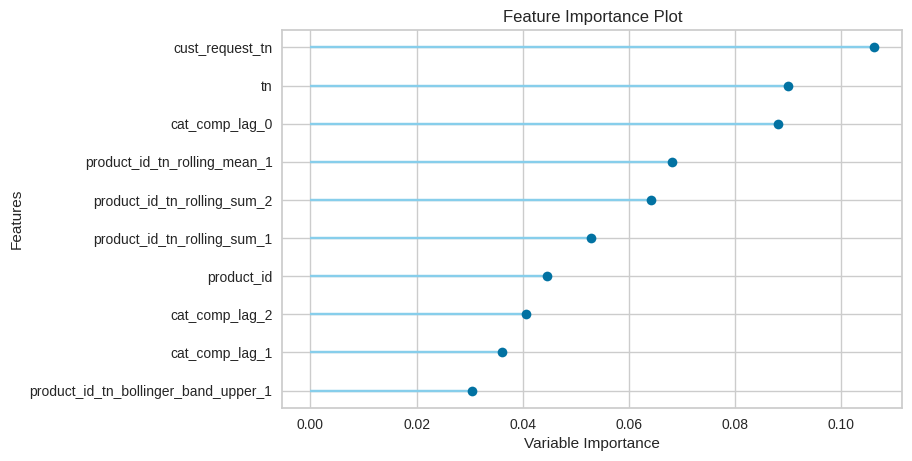

In [13]:
plot_model(model, plot = 'feature')

In [14]:
#interpret_model(model)

In [15]:
prediction_holdout = predict_model(model)

prediction_holdout

,Model,Error Rate
0,Extra Trees Regressor,24.2700


,product_id,tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,cat1,...,avg_cat_comp_q1,avg_cat_comp_q2,avg_cat_comp_q3,avg_cat_comp_q4,cat_comp_trend_q1,cat_comp_trend_q2,cat_comp_trend_q3,cat_comp_trend_q4,tn_mas_2,prediction_label
11697,20001,1660.01,0,392,1734.24,9,1,0,32,HC,...,187.10,170.65,266.06,31.93,-24.61,-194.27,268.62,-247.12,1397.37,1576.42
11698,20002,1090.19,0,438,1095.10,9,1,0,32,HC,...,80.25,103.10,304.67,601.94,-15.73,-122.30,250.01,-108.30,1423.58,1538.32
1408,20003,967.77,0,470,977.11,9,1,0,32,FOODS,...,311.87,63.78,222.18,146.37,-62.54,96.49,121.07,-178.69,948.29,1008.08
1409,20004,786.17,0,466,818.26,9,1,0,32,FOODS,...,188.76,93.92,191.38,95.97,40.80,-12.50,145.50,63.37,723.94,892.80
1410,20005,879.53,0,454,932.69,9,1,0,32,FOODS,...,39.72,389.56,8.07,374.20,75.76,-107.55,52.84,-9.43,606.91,870.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22862,21263,0.01,0,5,0.01,9,0,0,11,PC,...,0.01,0.03,0.11,0.20,-0.01,0.02,0.17,-0.25,0.03,0.05
29269,21265,0.02,0,8,0.02,9,0,0,6,PC,...,0.07,0.01,0.00,0.09,0.07,-0.10,0.02,-0.02,0.07,0.06
29270,21266,0.03,0,11,0.03,9,0,0,6,PC,...,0.07,0.03,0.01,0.07,0.06,-0.16,-0.02,0.07,0.07,0.07
29902,21267,0.02,0,7,0.02,9,0,0,6,PC,...,0.11,0.13,0.00,0.00,0.08,-0.06,0.00,0.00,0.04,0.06


In [16]:
#prediction_holdout[prediction_holdout.product_id==20001]

In [17]:
final_best = finalize_model(model)

In [18]:
final_best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['product_id', 'tn', 'cero_ventas',
                                             'cust_request_qty',
                                             'cust_request_tn', 'mes',
                                             'producto_estrella',
                                             'plan_precios_cuidados',
                                             'meses_historia_prod', 'sku_size',
                                             'temp_media', 'temp_min_media',
                                             'temp_max_media', 'IPC',
                                             'promedio_mens_dolar_venta',
                                             'dif_cust_request_tn',
                                             '...
                                                                    'cat2',
                                                                    'Cluster_dtw_1',
                                                                    'Cluster_dtw_2',
                                                                    'Cluster_dtw_3',
                                                                    'Cluster_dtw_4'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['cat3', 'cat_completo'],
                                    transformer=TargetEncoder(cols=['cat3',
                                                                    'cat_completo'],
                                                              handle_missing='return_nan'))),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=456456465))])

In [19]:
prediction_holdout.head()

,product_id,tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,cat1,...,avg_cat_comp_q1,avg_cat_comp_q2,avg_cat_comp_q3,avg_cat_comp_q4,cat_comp_trend_q1,cat_comp_trend_q2,cat_comp_trend_q3,cat_comp_trend_q4,tn_mas_2,prediction_label
11697,20001,1660.01,0,392,1734.24,9,1,0,32,HC,...,187.10,170.65,266.06,31.93,-24.61,-194.27,268.62,-247.12,1397.37,1576.42
11698,20002,1090.19,0,438,1095.10,9,1,0,32,HC,...,80.25,103.10,304.67,601.94,-15.73,-122.30,250.01,-108.30,1423.58,1538.32
1408,20003,967.77,0,470,977.11,9,1,0,32,FOODS,...,311.87,63.78,222.18,146.37,-62.54,96.49,121.07,-178.69,948.29,1008.08
1409,20004,786.17,0,466,818.26,9,1,0,32,FOODS,...,188.76,93.92,191.38,95.97,40.80,-12.50,145.50,63.37,723.94,892.80
1410,20005,879.53,0,454,932.69,9,1,0,32,FOODS,...,39.72,389.56,8.07,374.20,75.76,-107.55,52.84,-9.43,606.91,870.70


In [20]:
error_rate(prediction_holdout['tn_mas_2'], prediction_holdout['prediction_label'])

24.27

In [21]:
# Seleccionar las características (variables independientes) y la variable objetivo (tn_mas_2)
features = ['product_id', 'prediction_label']
df_final = prediction_holdout[features]
df_final

,product_id,prediction_label
11697,20001,1576.42
11698,20002,1538.32
1408,20003,1008.08
1409,20004,892.80
1410,20005,870.70
...,...,...
22862,21263,0.05
29269,21265,0.06
29270,21266,0.07
29902,21267,0.06


In [22]:
df_prods_prediccion=pd.read_csv(config.ARCH_PRODUCTOS_PREDICCION_FUTURE)

In [23]:
df_final = df_final[(df_final.product_id.isin(df_prods_prediccion.product_id))]

In [24]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 11697 to 29903
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        780 non-null    int32  
 1   prediction_label  780 non-null    float64
dtypes: float64(1), int32(1)
memory usage: 15.2 KB


In [25]:
len(df_final)

780

In [26]:
df_final.to_csv("/home/lumamdq/buckets/b1/datasets/pycaret_et_prediccion.csv",index=False)